<a href="https://colab.research.google.com/github/nejdet/MachineLearning/blob/master/audio_denoising_w_RNN/Audio_denoising_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AUDIO DENOISING WITH RECURRENT NEURAL NETWORKS**

Given notebook downloads 33.5 second long audio file. After sampling it with 16000 Hz sampling rate, it creates small patches which are overlapping 200 samples long each. 

Gaussian noise (white noise) with SNR = 10 is added to all samples. Noisy samples are fed to the model as input and original samples are fed as target value.

In [0]:
import math  
import os 
import numpy as np 
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
%matplotlib inline

# Importing Audio from Github

In [22]:
import urllib.request
github_path = 'https://raw.githubusercontent.com/nejdet/MachineLearning/master/audio_denoising_w_RNN/audio/wav_sample.wav'

audio_dir = 'audio'

if os.path.exists(audio_dir) == False:
    os.mkdir(audio_dir)

urllib.request.urlretrieve(github_path, audio_dir + '/wav_sample.wav')

('audio/wav_sample.wav', <http.client.HTTPMessage at 0x7f7076d69080>)

#Loading Audio File and Creating Noisy Audio File

In [0]:
# Function to create noise
def get_white_noise(signal,SNR) :
    # RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    
    # RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/20)))
    
    # Additive white gausian noise. Thereore mean=0, STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

# Load the orginal file
audio_file_path="/content/audio/wav_sample.wav"
clean_audio, sr = librosa.load(audio_file_path, sr=16000, duration=10)

# Creat the noisy file
noise=get_white_noise(clean_audio,SNR=10)
noisy_audio=np.clip(clean_audio+noise, -1, 1)

#Prepare Training and Test Splits

In [0]:
X_train, X_test, y_train, y_test = train_test_split(noisy_audio, clean_audio, test_size=0.25, random_state=42)

In [0]:
X_train_seq = []
y_train_seq = []
X_test_seq = []
y_test_seq = []
seq_len = 200
seq_step = 100

for i in range(seq_len, len(X_train)+1, seq_step):
    X_train_seq.append(X_train[i-seq_len:i])
    y_train_seq.append(y_train[i-seq_len:i])

for i in range(seq_len, len(X_test)+1, seq_step):
    X_test_seq.append(X_test[i-seq_len:i])
    y_test_seq.append(y_test[i-seq_len:i])


X_train_seq = np.asarray(X_train_seq).reshape(len(X_train_seq), seq_len, 1)
y_train_seq = np.asarray(y_train_seq).reshape(len(y_train_seq), seq_len, 1)
X_test_seq = np.asarray(X_test_seq).reshape(len(X_test_seq), seq_len, 1)
y_test_seq = np.asarray(y_test_seq).reshape(len(y_test_seq), seq_len, 1)

#Create and Compile the Model

In [26]:
# Model configuration
batch_size = 20
no_epochs = 20
verbosity = 1

input_shape = (X_train_seq.shape[1], 1)

# Create the model
model = Sequential()

model.add(LSTM(40, input_shape=input_shape, return_sequences=True))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(1, return_sequences=True))

model.summary()

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 40)           6720      
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 80)           38720     
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 1)            328       
Total params: 45,768
Trainable params: 45,768
Non-trainable params: 0
_________________________________________________________________


# Fit the Model to Dataset

In [27]:
history = model.fit(X_train_seq, y_train_seq,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_data=(X_test_seq, y_test_seq))

Epoch 1/20
60/60 [==============================] - 3s 44ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 2/20
60/60 [==============================] - 1s 25ms/step - loss: 0.0166 - val_loss: 0.0150
Epoch 3/20
60/60 [==============================] - 1s 25ms/step - loss: 0.0103 - val_loss: 0.0056
Epoch 4/20
60/60 [==============================] - 1s 25ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 5/20
60/60 [==============================] - 1s 24ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 6/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 7/20
60/60 [==============================] - 1s 25ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 8/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/20
60/60 [==============================] - 1s 24ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/20
60/60 [==============================] - 1s 25ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 11/

#Plot the Loss

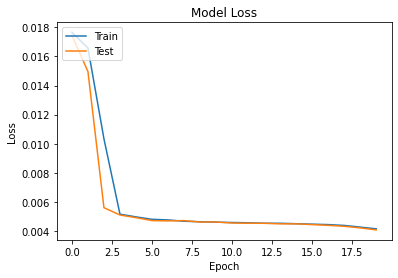

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Predict the Output for Test Set

In [29]:
y_pred_seq = model.predict(X_test_seq, batch_size=batch_size, verbose=verbosity)

20/20 [==============================] - 0s 10ms/step


#Compare the Signals

Only one patch of the signal was displayed

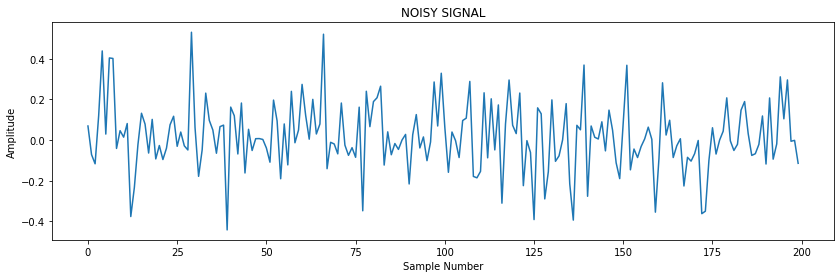

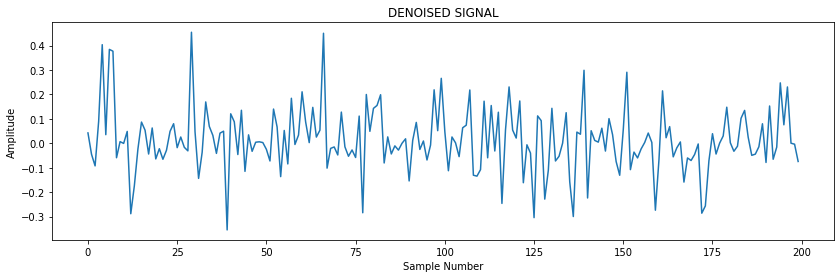

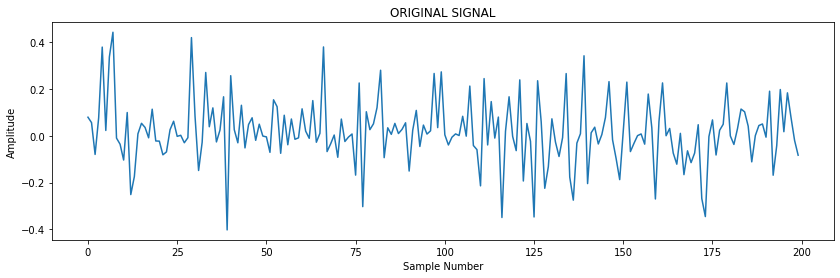

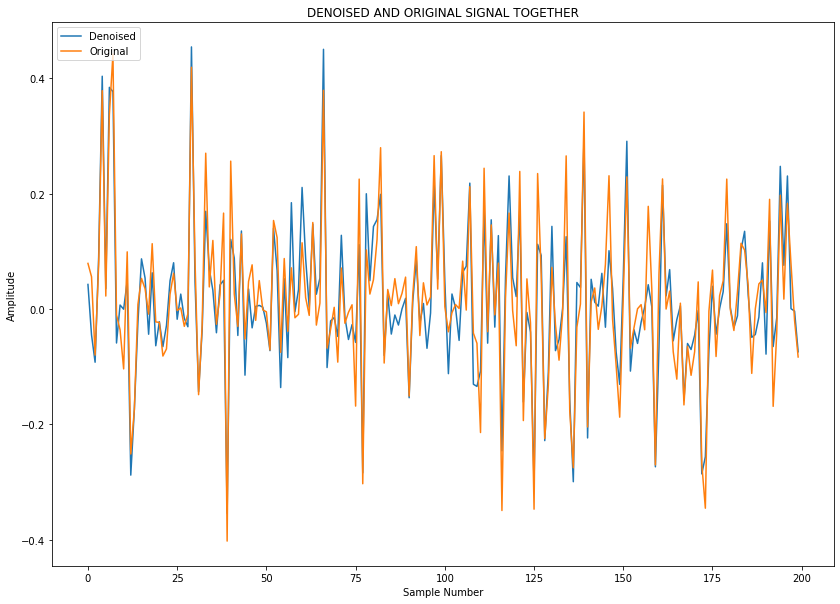

In [30]:
#analyze the frequency components in the signal
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.title('NOISY SIGNAL')
plt.plot(X_test_seq[0])
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

plt.title('DENOISED SIGNAL')
plt.plot(y_pred_seq[0])
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

plt.title('ORIGINAL SIGNAL')
plt.plot(y_test_seq[0])
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#Ploting denoised and original audio together
plt.plot(y_pred_seq[0])
plt.plot(y_test_seq[0])
plt.title('DENOISED AND ORIGINAL SIGNAL TOGETHER')
plt.ylabel('Amplitude')
plt.xlabel('Sample Number')
plt.legend(['Denoised', 'Original'], loc='upper left')
plt.show()